## 1. Get data

In [7]:
# import os
# import requests
# import zipfile
# from pathlib import Path

# # Setup path to data folder
# data_path = Path("../data")
# image_path = data_path / "pizza_steak_sushi"

# # If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#     print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)

# # Download pizza, steak, sushi data
# with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
#     print("Downloading pizza, steak, sushi data...")
#     f.write(request.content)

# # Unzip pizza, steak, sushi data
# with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#     print("Unzipping pizza, steak, sushi data...") 
#     zip_ref.extractall(image_path)<

# # Remove zip file
# os.remove(data_path / "pizza_steak_sushi.zip")


## 2. Create Datasets and DataLoaders 

In [8]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

## 3. Making a model

In [9]:
# https://github.com/d-li14/mobilenetv2.pytorch

In [10]:
from torch import nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['MobileNetV2', 'mobilenet_v2']


model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=None):
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=None):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self,
                 num_classes=1000,
                 width_mult=1.0,
                 inverted_residual_setting=None,
                 round_nearest=8,
                 block=None,
                 norm_layer=None):
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


def get_mobilenet_v2(pretrained=False, progress=True, with_out_classifier=True, **kwargs):
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        with_out_classifier (bool): If True, removes the classifier layer
    """
    model = MobileNetV2(**kwargs)
    
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    
    # Supprimer la dernière couche classifier si with_out_classifier est True
    if with_out_classifier:
        # Initialiser un nouveau module sans la dernière couche
        class MobileNetV2WithoutClassifier(nn.Module):
            def __init__(self, original_model):
                super(MobileNetV2WithoutClassifier, self).__init__()
                self.features = nn.Sequential(*list(original_model.children())[:-1])

            def forward(self, x):
                return self.features(x)

        # Retourner une instance de MobileNetV2WithoutClassifier
        return MobileNetV2WithoutClassifier(model)
    else:
        # Retourner le modèle complet
        return model

# Exemple d'utilisation
get_mobilenet_v2_pretrained = get_mobilenet_v2(pretrained=True, progress=True, with_out_classifier=True)


In [11]:
model_without_classifier = get_mobilenet_v2(pretrained=True, progress=True, with_out_classifier=True)
feature_96 = model_without_classifier.features[0][2]
feature_144 = model_without_classifier.features[0][4]
feature_192 = model_without_classifier.features[0][7]
feature_576 = model_without_classifier.features[0][14]
feature_1280 = list(model_without_classifier.features[0][18])[-1]
model_without_classifier.features[0][:5]


Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
from torchviz import make_dot


class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class AutoSegNet(nn.Module):
    def __init__(self, pretrained=True):
        super(AutoSegNet, self).__init__()
        mobilenet = mobilenet_v2(pretrained=pretrained)
        self.encoder = mobilenet.features
        self.decoder = nn.ModuleList([
            ConvBNReLU(1280, 256, kernel_size=1),
            ConvBNReLU(576, 256, kernel_size=1),
            ConvBNReLU(192, 256, kernel_size=1),
            ConvBNReLU(144, 256, kernel_size=1),
            ConvBNReLU(96, 256, kernel_size=1)
        ])
        self.final_conv = nn.Conv2d(256 * 4, 12, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        features = []
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i in {3, 6, 13, 17, 18}:  # Indices where we need features for decoder
                features.append(x)

        # Decoder
        upsampled_features = []
        for i, (decoder_layer, feature) in enumerate(zip(self.decoder, features)):
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = x + decoder_layer(feature)
            upsampled_features.append(x)

        # Final Concatenation and Classification
        x = torch.cat(upsampled_features, dim=1)
        x = self.final_conv(x)
        x = F.softmax(x, dim=1)

        return x


auto_seg_net = AutoSegNet()
mob_v2 = mobilenet_v2(pretrained=True)


/home/branis/GitHub/Intelligent-Semantic-Segmentation-for-Self-Driving-Vehicles-Using-Deep-Learning/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/branis/GitHub/Intelligent-Semantic-Segmentation-for-Self-Driving-Vehicles-Using-Deep-Learning/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:

# Générer une visualisation du graphe
# x = torch.randn(1, 3, 450, 450)
# y = auto_seg_net(x)
# make_dot(y, params=dict(auto_seg_net.named_parameters()))
mob_v2.features[18][-1]

ReLU6(inplace=True)

In [91]:
import torch



class ConvBNReLU(nn.Module):
    def __init__(self, in_channels):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3)
        self.bn = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class AutoSegNet(nn.Module):
    def __init__(self, pretrained=True):
        super(AutoSegNet, self).__init__()
        # self.mobil_net_v2 =  get_mobilenet_v2(pretrained=pretrained, progress=True, with_out_classifier=True).features[0]
        self.mobile_net_v2 = mobilenet_v2(pretrained=pretrained).features
    def forward(self, x):
        # # Encoder
        x_0 = self.mobile_net_v2[2].conv[0][-1](x)
        x_1 = self.mobile_net_v2[4].conv[0][-1](x_0)
        x_2 = self.mobile_net_v2[7].conv[0][-1](x_1)
        x_3 = self.mobile_net_v2[14].conv[0][-1](x_2)
        x_4 = self.mobile_net_v2[18][-1](x_3)
        
        # Decoder "UpSampling satge 1"
        # x_5 = nn.Conv2d(in_channels=1280, out_channels=256, kernel_size=1)(x_4)
        # x_5 = nn.Upsample(scale_factor=2, mode='nearest')(x_5)
        # x_5 = x_5 + nn.Conv2d(in_channels=576, out_channels=256, kernel_size=1)(x_3)
        # x_5 = nn.Conv2d(in_channels=576, out_channels=256, kernel_size=1)(x_3)
        
        # x_6 = nn.Upsample(scale_factor=2, mode='nearest')(x_5)
        # x_6 = x_6 + nn.Conv2d(in_channels=192, out_channels=256, kernel_size=1)(x_2)
        
        # x_7 = nn.Upsample(scale_factor=2, mode='nearest')(x_6)
        # x_7 = x_7 + nn.Conv2d(in_channels=144, out_channels=256, kernel_size=1)(x_1)
        
        # x_8 = nn.Upsample(scale_factor=2, mode='nearest')(x_7)
        # x_8 = x_8 + nn.Conv2d(in_channels=96, out_channels=256, kernel_size=1)(x_0)
        
        
        # # Decoder "UpSampling satge 2"
        # x_9 = ConvBNReLU(in_channels=256)(x_5)
        # x_9 = ConvBNReLU(in_channels=128)(x_9)
        # x_9 = nn.Upsample(scale_factor=8, mode='nearest')(x_9)
        
        # x_10 = ConvBNReLU(in_channels=256)(x_6)
        # x_10 = ConvBNReLU(in_channels=128)(x_10)
        # x_10 = nn.Upsample(scale_factor=4, mode='nearest')(x_10)
        
        # x_11 = ConvBNReLU(in_channels=256)(x_7)
        # x_11 = ConvBNReLU(in_channels=128)(x_11)
        # x_11 = nn.Upsample(scale_factor=2, mode='nearest')(x_11)
        
        # x_12 = ConvBNReLU(in_channels=256)(x_8)
        # x_12 = ConvBNReLU(in_channels=128)(x_12)
       
        
        # # Classification / Segmentation
        # x_13 = torch.cat((x_9, x_10, x_11, x_12), dim=1)
        # x_13 = ConvBNReLU(in_channels=512)(x_13)
        # x_13 = nn.Upsample(scale_factor=2, mode='nearest')(x_13)
        # x_13 = nn.Conv2d(in_channels=128, out_channels=12, kernel_size=3)(x_13)
        # x_13 = nn.Softmax()
        
        # return x_13
        return x_4
              
auto_seg_net = AutoSegNet()


In [94]:
# torch.Size([1, 256, 30, 30])

x = torch.randn(1, 3, 450, 450)
y = auto_seg_net(x)
# make_dot(y, params=dict(auto_seg_net.named_parameters()))
y.size()


torch.Size([1, 3, 450, 450])

In [63]:
# Création d'un tenseur d'exemple avec une taille de 3x3
import torch
input_tensor = torch.randn(1, 200, 200)

# Upsampling de 2
upsample_layer = nn.Conv2d(1, 1, kernel_size=1, stride=2)
output_tensor = upsample_layer(input_tensor)

print("Input tensor shape:", input_tensor.shape)
print("Output tensor shape after upsampling:", output_tensor.shape)

Input tensor shape: torch.Size([1, 200, 200])
Output tensor shape after upsampling: torch.Size([1, 100, 100])


## 4. Creating train_step() and test_step() functions and train() to combine them

In [18]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and y_pred_classaccumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results


## 5. Creating a function to save the model (utils.py)

In [19]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

## 6. Train, evaluate and save the model (train.py)

In [20]:
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch

from torchvision import transforms
torch.autograd.set_detect_anomaly(True)

# Setup hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "../data/pizza_steak_sushi/train"
test_dir = "../data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
model = get_mobilenet_v2(pretrained=True, progress=True).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=NUM_EPOCHS,
      device=device)

# Save the model with help from utils.py
save_model(model=model,
          target_dir="../models",
          model_name="MobileNetV2.pth")

  5%|▌         | 1/20 [00:03<01:05,  3.45s/it]

Epoch: 1 | train_loss: 6.8349 | train_acc: 0.3008 | test_loss: 14.7334 | test_acc: 0.4025


 10%|█         | 2/20 [00:06<01:00,  3.37s/it]

Epoch: 2 | train_loss: 1.0745 | train_acc: 0.7617 | test_loss: 9.2886 | test_acc: 0.5578


 15%|█▌        | 3/20 [00:10<00:56,  3.33s/it]

Epoch: 3 | train_loss: 0.3901 | train_acc: 0.9141 | test_loss: 1.5114 | test_acc: 0.7926


 20%|██        | 4/20 [00:13<00:53,  3.32s/it]

Epoch: 4 | train_loss: 0.1398 | train_acc: 0.9727 | test_loss: 1.5952 | test_acc: 0.7216


 25%|██▌       | 5/20 [00:16<00:49,  3.32s/it]

Epoch: 5 | train_loss: 0.5635 | train_acc: 0.8398 | test_loss: 1.5927 | test_acc: 0.7415


 30%|███       | 6/20 [00:19<00:46,  3.31s/it]

Epoch: 6 | train_loss: 0.3884 | train_acc: 0.8555 | test_loss: 1.4674 | test_acc: 0.7216


 35%|███▌      | 7/20 [00:23<00:42,  3.28s/it]

Epoch: 7 | train_loss: 0.2536 | train_acc: 0.8555 | test_loss: 1.9169 | test_acc: 0.7225


 40%|████      | 8/20 [00:26<00:39,  3.28s/it]

Epoch: 8 | train_loss: 0.2907 | train_acc: 0.8594 | test_loss: 1.4397 | test_acc: 0.7519


 45%|████▌     | 9/20 [00:29<00:35,  3.27s/it]

Epoch: 9 | train_loss: 0.3897 | train_acc: 0.8359 | test_loss: 1.2215 | test_acc: 0.7216


 50%|█████     | 10/20 [00:32<00:32,  3.27s/it]

Epoch: 10 | train_loss: 0.6353 | train_acc: 0.8516 | test_loss: 1.2759 | test_acc: 0.7831


 55%|█████▌    | 11/20 [00:36<00:29,  3.29s/it]

Epoch: 11 | train_loss: 0.3160 | train_acc: 0.8711 | test_loss: 1.5060 | test_acc: 0.8239


 60%|██████    | 12/20 [00:39<00:26,  3.29s/it]

Epoch: 12 | train_loss: 0.4269 | train_acc: 0.8242 | test_loss: 0.9374 | test_acc: 0.7623


 65%|██████▌   | 13/20 [00:42<00:22,  3.27s/it]

Epoch: 13 | train_loss: 0.3668 | train_acc: 0.8672 | test_loss: 0.9245 | test_acc: 0.7718


 70%|███████   | 14/20 [00:46<00:19,  3.29s/it]

Epoch: 14 | train_loss: 0.5259 | train_acc: 0.8594 | test_loss: 1.3048 | test_acc: 0.7330


 75%|███████▌  | 15/20 [00:49<00:16,  3.27s/it]

Epoch: 15 | train_loss: 0.3177 | train_acc: 0.8594 | test_loss: 0.8822 | test_acc: 0.7623


 80%|████████  | 16/20 [00:52<00:13,  3.27s/it]

Epoch: 16 | train_loss: 0.2295 | train_acc: 0.8516 | test_loss: 0.9282 | test_acc: 0.7633


 85%|████████▌ | 17/20 [00:55<00:09,  3.28s/it]

Epoch: 17 | train_loss: 0.0712 | train_acc: 0.9883 | test_loss: 1.0098 | test_acc: 0.7633


 90%|█████████ | 18/20 [00:59<00:06,  3.26s/it]

Epoch: 18 | train_loss: 0.3920 | train_acc: 0.8750 | test_loss: 0.5972 | test_acc: 0.8447


 95%|█████████▌| 19/20 [01:03<00:03,  3.52s/it]

Epoch: 19 | train_loss: 0.4291 | train_acc: 0.8711 | test_loss: 0.8246 | test_acc: 0.8646


100%|██████████| 20/20 [01:06<00:00,  3.33s/it]

Epoch: 20 | train_loss: 0.1235 | train_acc: 1.0000 | test_loss: 1.0689 | test_acc: 0.7225
[INFO] Saving model to: ../models/MobileNetV2.pth


In [21]:
# Import model
model = MobileNetV2(in_channels=3, num_classes=3).to(device)
model.load_state_dict(torch.load("../weights/MobileNetV2.pth"))
model.eval()

TypeError: __init__() got an unexpected keyword argument 'in_channels'

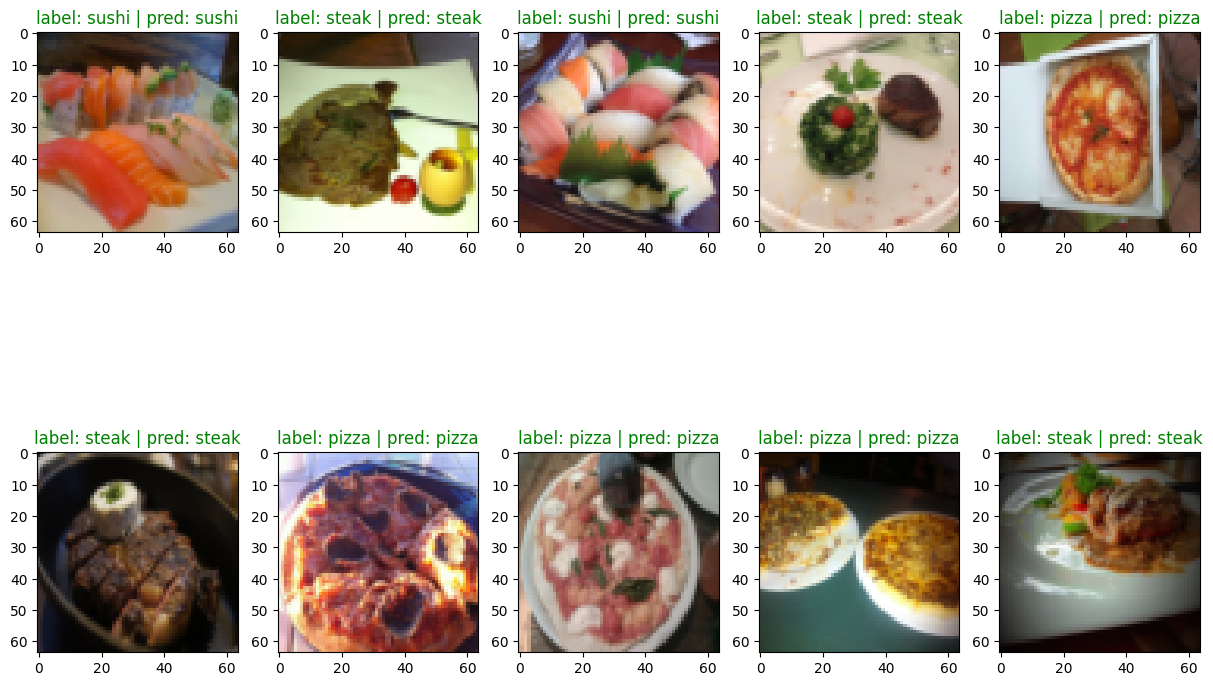

In [22]:
import random
import matplotlib.pyplot as plt

# Get a batch of training features and labels
train_features, train_labels = next(iter(train_dataloader))

# Define the number of images to display
nb_images = 10

# Choose random images from the batch
random_images = True
batch_size = train_features.size()[0]
ids = random.sample(range(0, batch_size), nb_images) if random_images else range(0, nb_images)
images = train_features[ids]
labels = train_labels[ids]

# Plot the images along with their labels and predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
for ax, image, label in zip(axes.flatten(), images, labels):
    # Make prediction using the model
    pred = model(image.unsqueeze(0)).argmax().item()

    # Define the title color based on label and pred equality
    title_color = 'green' if label == pred else 'red'

    # Display the image with the title color
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"label: {class_names[label]} | pred: {class_names[pred]}", color=title_color)


plt.show()


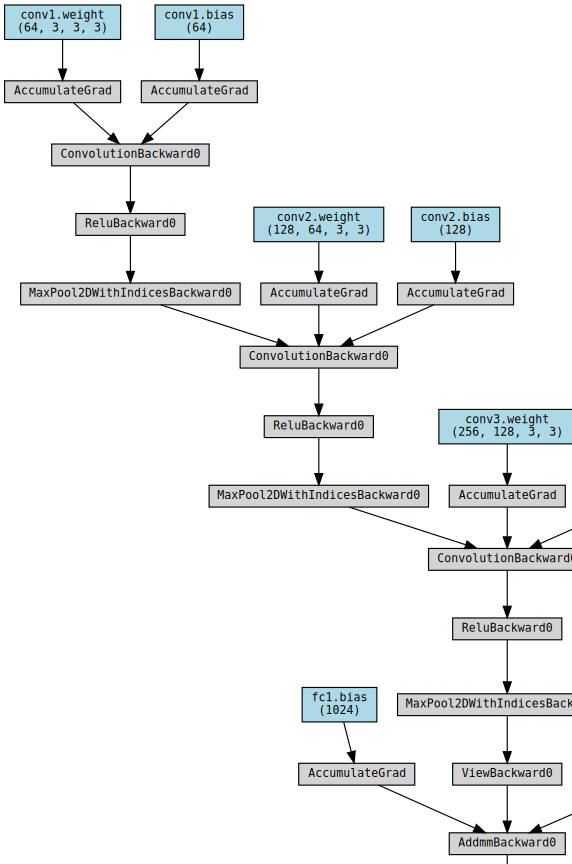

In [143]:
import torch
import torch.nn as nn
from torchviz import make_dot

class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Créer une instance de votre modèle
model = ComplexModel()

# Générer une visualisation du graphe
x = torch.randn(1, 3, 32, 32)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))
